# Ploting Surface Brightness Profile

In [4]:
%matplotlib inline

import os
import copy

import numpy as np

from astropy.io import fits
from astropy import wcs

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
from matplotlib.ticker import NullFormatter, MaxNLocator, FormatStrFormatter

import sep

from kungpao import imtools
from kungpao import io
from kungpao.display import display_single, IMG_CMAP, SEG_CMAP
from kungpao.galsbp import galSBP

rcParams['figure.figsize'] = [10., 8.]
sep.set_extract_pixstack(1000000)
plt.rc('text', usetex=True)

SystemExit: 
Your "iraf" and "IRAFARCH" environment variables are not defined and could not
be determined from /usr/local/bin/cl.  These are needed to find IRAF tasks.
Before starting pyraf, define them by doing (for example):

    setenv iraf /iraf/iraf/
    setenv IRAFARCH linux

at the Unix command line. Actual values will depend on your IRAF installation,
and they are set during the IRAF user installation (see iraf.net), or via
Ureka installation (see http://ssb.stsci.edu/ureka).  Also be sure to run the
"mkiraf" command to create a logion.cl (http://www.google.com/search?q=mkiraf).


In [2]:
prefix = 'HSC_tractor'

#### Define rebin and congrid functions

In [3]:
# From http://martynbristow.co.uk/wordpress/blog/rebinning-data/
# It's a little bit slow, but flux is conserved
def rebin(array, dimensions=None, scale=None):
    """ Return the array ``array`` to the new ``dimensions`` conserving flux the flux in the bins
    The sum of the array will remain the same
 
    >>> ar = numpy.array([
        [0,1,2],
        [1,2,3],
        [2,3,4]
        ])
    >>> rebin(ar, (2,2))
    array([
        [1.5, 4.5]
        [4.5, 7.5]
        ])
    Raises
    ------
 
    AssertionError
        If the totals of the input and result array don't agree, raise an error because computation may have gone wrong
 
    Reference
    =========
    +-+-+-+
    |1|2|3|
    +-+-+-+
    |4|5|6|
    +-+-+-+
    |7|8|9|
    +-+-+-+
    """
    if dimensions is not None:
        if isinstance(dimensions, float):
            dimensions = [int(dimensions)] * len(array.shape)
        elif isinstance(dimensions, int):
            dimensions = [dimensions] * len(array.shape)
        elif len(dimensions) != len(array.shape):
            raise RuntimeError('')
    elif scale is not None:
        if isinstance(scale, float) or isinstance(scale, int):
            dimensions = map(int, map(round, map(lambda x: x*scale, array.shape)))
        elif len(scale) != len(array.shape):
            raise RuntimeError('')
    else:
        raise RuntimeError('Incorrect parameters to rebin.\n\trebin(array, dimensions=(x,y))\n\trebin(array, scale=a')
    print dimensions
    print "Rebinning to Dimensions: %s, %s" % tuple(dimensions)
    import itertools
    dY, dX = map(divmod, map(float, array.shape), dimensions)
 
    result = np.zeros(dimensions)
    for j, i in itertools.product(*map(xrange, array.shape)):
        (J, dj), (I, di) = divmod(j*dimensions[0], array.shape[0]), divmod(i*dimensions[1], array.shape[1])
        (J1, dj1), (I1, di1) = divmod(j+1, array.shape[0]/float(dimensions[0])), divmod(i+1, array.shape[1]/float(dimensions[1]))
         
        # Moving to new bin
        # Is this a discrete bin?
        dx,dy=0,0
        if (I1-I == 0) | ((I1-I == 1) & (di1==0)):
            dx = 1
        else:
            dx=1-di1
        if (J1-J == 0) | ((J1-J == 1) & (dj1==0)):
            dy=1
        else:
            dy=1-dj1
        # Prevent it from allocating outide the array
        I_=min(dimensions[1]-1,I+1)
        J_=min(dimensions[0]-1,J+1)
        result[J, I] += array[j,i]*dx*dy
        result[J_, I] += array[j,i]*(1-dy)*dx
        result[J, I_] += array[j,i]*dy*(1-dx)
        result[J_, I_] += array[j,i]*(1-dx)*(1-dy)
    allowError = 0.1
    assert (array.sum() < result.sum() * (1+allowError)) & (array.sum() >result.sum() * (1-allowError))
    return result

In [4]:
import scipy.interpolate
import scipy.ndimage
def congrid(a, newdims, method='linear', centre=False, minusone=False):
    '''Arbitrary resampling of source array to new dimension sizes.
    Currently only supports maintaining the same number of dimensions.
    To use 1-D arrays, first promote them to shape (x,1).
    
    Uses the same parameters and creates the same co-ordinate lookup points
    as IDL''s congrid routine, which apparently originally came from a VAX/VMS
    routine of the same name.

    method:
    neighbour - closest value from original data
    nearest and linear - uses n x 1-D interpolations using
                         scipy.interpolate.interp1d
    (see Numerical Recipes for validity of use of n 1-D interpolations)
    spline - uses ndimage.map_coordinates

    centre:
    True - interpolation points are at the centres of the bins
    False - points are at the front edge of the bin

    minusone:
    For example- inarray.shape = (i,j) & new dimensions = (x,y)
    False - inarray is resampled by factors of (i/x) * (j/y)
    True - inarray is resampled by(i-1)/(x-1) * (j-1)/(y-1)
    This prevents extrapolation one element beyond bounds of input array.
    '''
    if not a.dtype in [np.float64, np.float32]:
        a = np.cast[float](a)

    m1 = np.cast[int](minusone)
    ofs = np.cast[int](centre) * 0.5
    old = np.array( a.shape )
    ndims = len( a.shape )
    if len( newdims ) != ndims:
        print "[congrid] dimensions error. " \
              "This routine currently only support " \
              "rebinning to the same number of dimensions."
        return None
    newdims = np.asarray( newdims, dtype=float )
    dimlist = []

    if method == 'neighbour':
        for i in range( ndims ):
            base = np.indices(newdims)[i]
            dimlist.append( (old[i] - m1) / (newdims[i] - m1) \
                            * (base + ofs) - ofs )
        cd = np.array( dimlist ).round().astype(int)
        newa = a[list( cd )]
        return newa

    elif method in ['nearest','linear']:
        # calculate new dims
        for i in range( ndims ):
            base = np.arange( newdims[i] )
            dimlist.append( (old[i] - m1) / (newdims[i] - m1) \
                            * (base + ofs) - ofs )
        # specify old dims
        olddims = [np.arange(i, dtype = np.float) for i in list( a.shape )]

        # first interpolation - for ndims = any
        mint = scipy.interpolate.interp1d( olddims[-1], a, kind=method )
        newa = mint( dimlist[-1] )

        trorder = [ndims - 1] + range( ndims - 1 )
        for i in range( ndims - 2, -1, -1 ):
            newa = newa.transpose( trorder )

            mint = scipy.interpolate.interp1d( olddims[i], newa, kind=method )
            newa = mint( dimlist[i] )

        if ndims > 1:
            # need one more transpose to return to original dimensions
            newa = newa.transpose( trorder )

        return newa
    elif method in ['spline']:
        oslices = [ slice(0,j) for j in old ]
        oldcoords = np.ogrid[oslices]
        nslices = [ slice(0,j) for j in list(newdims) ]
        newcoords = np.mgrid[nslices]

        newcoords_dims = range(np.rank(newcoords))
        #make first index last
        newcoords_dims.append(newcoords_dims.pop(0))
        newcoords_tr = newcoords.transpose(newcoords_dims)
        # makes a view that affects newcoords

        newcoords_tr += ofs

        deltas = (np.asarray(old) - m1) / (newdims - m1)
        newcoords_tr *= deltas

        newcoords_tr -= ofs

        newa = scipy.ndimage.map_coordinates(a, newcoords)
        return newa
    else:
        print "Congrid error: Unrecognized interpolation type.\n", \
              "Currently only \'neighbour\', \'nearest\',\'linear\',", \
              "and \'spline\' are supported."
        return None

#### Import images

In [5]:
ra_cen = 129.603676                  # ra of object
dec_cen = -1.606419                  # dec of object
pixel_scale = 0.168
redshift = 0.052043

from astropy import cosmology
cosmos = cosmology.FlatLambdaCDM(H0=70, Om0=0.27)
ang_dis = cosmos.angular_diameter_distance(redshift)
phys_size = ang_dis.value/206265*1000 # kpc/arcsec
print 'At this redshift, 1 arcsec =', phys_size, 'kpc'

At this redshift, 1 arcsec = 1.01616618242 kpc


In [6]:
img = fits.open('./Images/img_tractor.fits')[0]
w = wcs.WCS(fits.open('./Images/cut_HSC_r.fits')[0])
data = img.data.byteswap().newbyteorder() # This is neccesary for 'sep' to operate

cen = img.data.shape[0]/2  # Central position of the image
print 'Size (in pixel):', [cen*2, cen*2]
print 'Angular size (in arcsec):', [cen*2*pixel_scale, cen*2*pixel_scale]
print 'The center of this image:', [cen, cen]

Size (in pixel): [1786, 1786]
Angular size (in arcsec): [300.048, 300.048]
The center of this image: [893, 893]


### Masking
#### Use `sep` to generate backgroud and substract it, then we use this subtracted image to extract objects.

Text(0.5,1,'substract background')

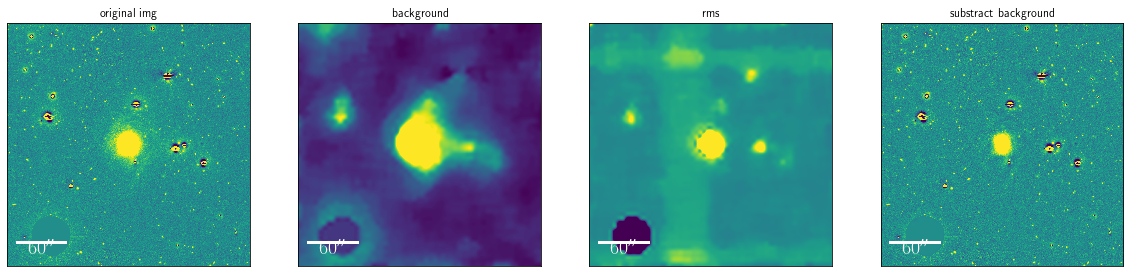

In [7]:
b = 30  # Box size
f = 5   # Filter width
bkg = sep.Background(data, bw=b, bh=b, fw=f, fh=f)
data_sub = data - bkg.back()

fig, ax = plt.subplots(1, 4, figsize=(20,8), sharey=True)
display_single(data, contrast=0.2, scale_bar=True, scale_bar_length=60, ax = ax[0], pixel_scale=pixel_scale)
ax[0].set_title('original img')

display_single(bkg.back(), contrast=0.2, scale_bar=True, scale_bar_length=60, ax=ax[1], pixel_scale=pixel_scale)
ax[1].set_title('background')

display_single(bkg.rms(), contrast=0.2, scale_bar=True, scale_bar_length=60, ax=ax[2], pixel_scale=pixel_scale)
ax[2].set_title('rms')

display_single(data_sub, contrast=0.2, scale_bar=True, scale_bar_length=60, ax = ax[3], pixel_scale=pixel_scale)
ax[3].set_title('substract background')

#### Extract objects, with threshold = sigma. The threshold here tends to be higher, in order to detect objects more aggresively.

In [81]:
sigma = 4
objects, segmap = sep.extract(data_sub, sigma, err=bkg.globalrms, segmentation_map=True, filter_type='matched')
print("# Detect %d objects" % len(objects))

# Detect 440 objects


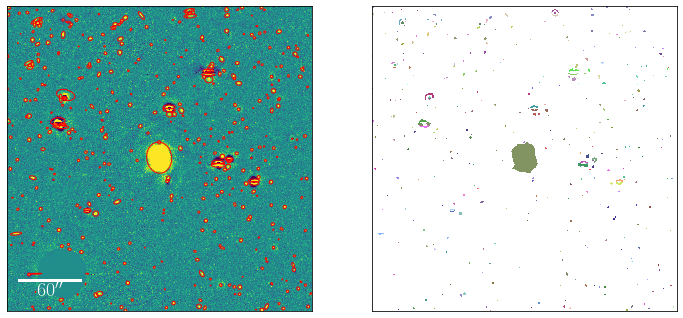

In [82]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots(1,2, figsize=(12,6))

display_single(data_sub, ax=ax[0], scale_bar_length=60, pixel_scale=pixel_scale)

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=8*objects['a'][i],
                height=8*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax[0].add_artist(e)
    
_ = display_single(segmap, scale='linear', cmap=SEG_CMAP , ax=ax[1])

#### Remove the central galaxy

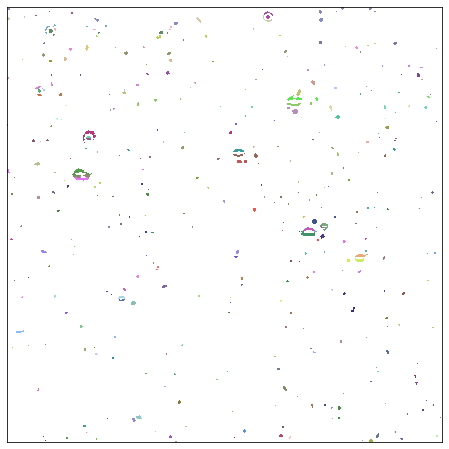

In [83]:
seg_nocen = imtools.seg_remove_cen_obj(segmap)
_ = display_single(seg_nocen, scale='linear', cmap=SEG_CMAP)

#### Convolve the mask to make it larger

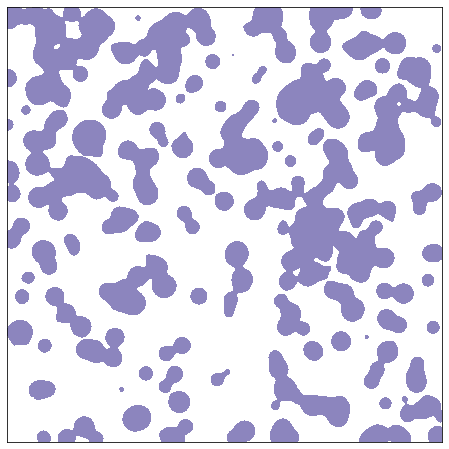

In [84]:
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
seg_conv = copy.deepcopy(seg_nocen)
seg_conv[seg_nocen > 0] = 1

# Convolve the image with a Gaussian kernel with the width of 5 pixel
# This is actually pretty slow, because the image is very large. 
seg_conv = convolve(seg_conv.astype('float'), Gaussian2DKernel(20.0))

seg_mask = seg_conv >= 0.005

_ = display_single(seg_mask.astype(int), cmap=SEG_CMAP)

### Evaluate sky background
#### Here we create a low-threshold object extraction.

In [62]:
obj_lthre, seg_lthre = sep.extract(data - bkg.globalback, 4.0,
                                   err=bkg.globalrms, 
                                   minarea=20, 
                                   deblend_nthresh=20, deblend_cont=0.1,
                                   clean=True, clean_param=1.0,
                                   segmentation_map=True)

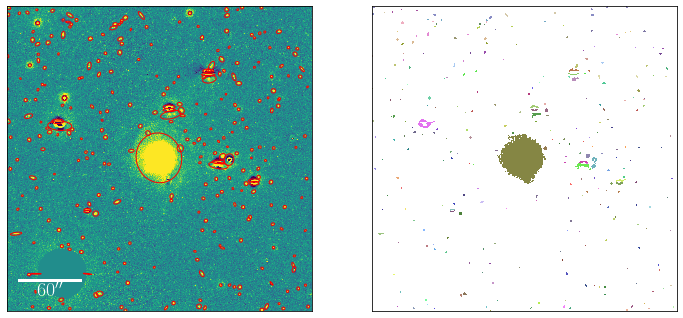

In [63]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots(1,2, figsize=(12,6))
display_single(data - bkg.globalback, ax=ax[0], scale_bar_length=60, pixel_scale=pixel_scale)

# plot an ellipse for each object
for i in range(len(obj_lthre)):
    e = Ellipse(xy=(obj_lthre['x'][i], obj_lthre['y'][i]),
                width=8*obj_lthre['a'][i],
                height=8*obj_lthre['b'][i],
                angle=obj_lthre['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax[0].add_artist(e)
    
display_single(seg_lthre, scale='linear', cmap=SEG_CMAP , ax=ax[1])

#### Convolve it to make it larger. The radius of kernel here can be larger than previous.

In [14]:
seg_conv = copy.deepcopy(seg_lthre)
seg_conv[seg_lthre > 0] = 1

# Convolve the image with a Gaussian kernel with the width of 15 pixel
bkg_mask = convolve(seg_conv.astype('float'), Gaussian2DKernel(15.0))

bkg_mask = bkg_mask >= 0.005

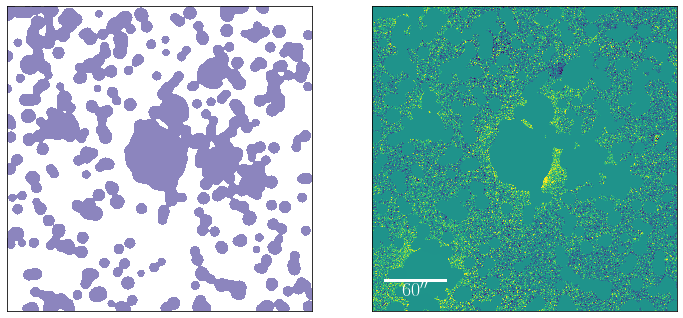

In [15]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
display_single(bkg_mask.astype(int), cmap=SEG_CMAP, ax=ax[0])
display_single((~bkg_mask)*(data - bkg.globalback), ax=ax[1], 
               scale_bar_length=60, pixel_scale=pixel_scale)

#### Plot a histogram to check the background substraction of this image

/anaconda3/envs/iraf27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


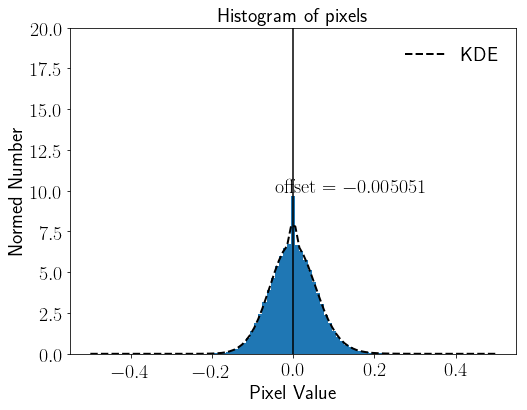

In [16]:
from scipy import stats

pix_data = data[~bkg_mask]

samp = pix_data

# `ppf()`: percent point function (inverse of cdf — percentiles).
x = np.linspace(-0.5, 0.5, 100)
gkde = stats.gaussian_kde(dataset=samp)

# `gkde.evaluate()` estimates the PDF itself.
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x, gkde.evaluate(x), linestyle='dashed', c='black', lw=2,
        label='KDE')
ax.hist(pix_data, bins=x, normed=1)
ax.legend(loc='best', frameon=False, fontsize=20)


ax.set_title('Histogram of pixels', fontsize=20)
ax.set_xlabel('Pixel Value', fontsize=20)
ax.set_ylabel('Normed Number', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_ylim(0,20)
offset = x[np.argmax(gkde.evaluate(x))]
ax.text(-0.045, 10, r'$\mathrm{offset}='+str(round(offset, 6))+'$', fontsize=20)
plt.vlines(np.median(samp), 0, 20)

In [17]:
np.median(samp)

0.0

#### Generate background from this masked image, and produce a corrected image `img_corr`

# Mean Sky / RMS Sky =   -0.00344 /    0.05294


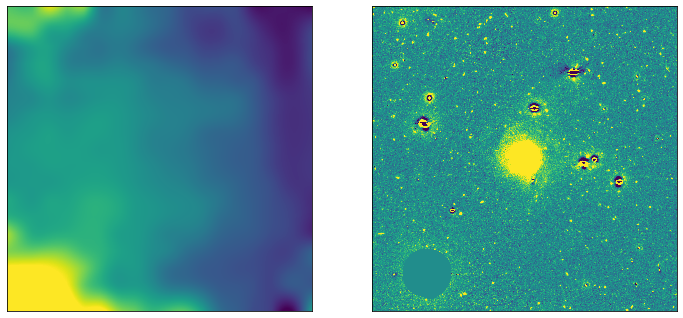

In [18]:
##### If you trust your original sky subtraction, this step may not be necessary
##### Here it is just for demonstration

bkg_global = sep.Background(data, 
                            mask=bkg_mask, maskthresh=0,
                            bw=100, bh=100, 
                            fw=20, fh=20)

print("# Mean Sky / RMS Sky = %10.5f / %10.5f" % (bkg_global.globalback, bkg_global.globalrms))

fig, ax = plt.subplots(1,2, figsize=(12,6))
display_single(bkg_global.back(), contrast=0.5, scale_bar=None, ax=ax[0])

img_corr = data - bkg_global.globalback

_ = display_single(img_corr, contrast=0.3, scale_bar=None, ax=ax[1])

#### Save the corrected image and also mask to  `fits` files under the current directory

In [85]:
img_fits = './img_'+prefix+'.fits'
msk_fits = './msk_'+prefix+'.fits'

_ = io.save_to_fits(data, img_fits)
_ = io.save_to_fits(seg_mask.astype('uint8'), msk_fits)

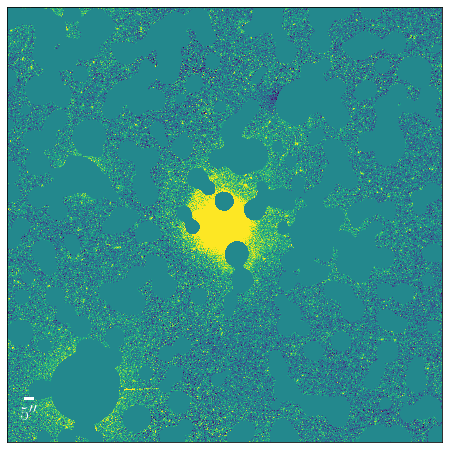

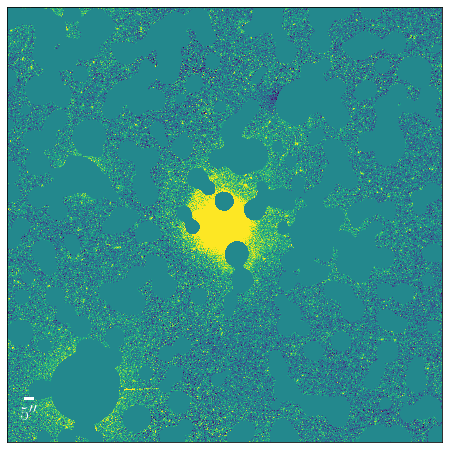

In [86]:
display_single(data*(~seg_mask))

## 1-D Surface Brightness Profile

#### First Run: Fix center, let other parameters be free

In [87]:
# Before runnning Ellipse, we need to know something about the galaxy 
# Centeral coordinate 
x_cen, y_cen = cen, cen

# Initial guess of axis ratio and position angle 
ba_ini, pa_ini = 0.7, 90.0

# Initial radius of Ellipse fitting
sma_ini = 10.0

# Minimum and maximum radiuse of Ellipse fitting
sma_min, sma_max = 0.0, 1000.0

# Stepsize of Ellipse fitting
# By default we are not using linear step size
step = 0.10

# Behaviour of Ellipse fitting
# Ellipse can fix certain parameters at the input values or fit everything
stage = 1    # Fit everything, let the center, shape of each isophote to be free
stage = 2    # Fix the central coordinate of every isophote at the x_cen / y_cen position
stage = 3    # Fix the central coordinate and shape of every isophote at input values
stage = 4    # This is the "force photometry" mode, need an external Ellipse output binary table as template (use `inEllip` parameter)
# Here we start with step 1
stage = 2

# Pixel scale of the image
# Used to convert the intensity into surface brightness unit
# Since we do not have WCS here, I just write down 1.0 pixel / arcsec
# pix_scale = -1/(img.header['PC1_1']*3600)

# Photometric zeropoint 
# Used to convert the intensity into surface brightness unit
# I am not sure about the calibration details, so just put 0.0 for now
zeropoint = 27.0

# Exposure time
# Used to convert the intensity into surface brightness unit
# I assume the image is normalized into 1 sec exposure time
exptime = 1.0

# Along each isophote, Elipse will perform sigmal clipping to remove problematic pixels
# The behaviour is decided by these three parameters: Number of sigma cliping, lower, and upper clipping threshold 
n_clip, low_clip, upp_clip = 1, 3.0, 3.0

# After the clipping, Ellipse can use the mean, median, or bi-linear interpolation of the remain pixel values
# as the "average intensity" of that isophote 
integrade_mode = 'median'   # or 'mean', or 'bi-linear'

ISO = '/Users/jiaxuanli/Research/kungpao/kungpao/iraf/macosx/x_isophote.e'
# This is where `x_isophote.e` exists

TBL = '/Users/jiaxuanli/Research/kungpao/kungpao/iraf/macosx/x_ttools.e'
# This is where `x_ttools.e` exists. Actually it's no need to install IRAF at all.

# Start running Ellipse like this 
# Step 1 will take a long time, ~ 10 mins on my computer, you can use larger stepsize to shorten the process
ell_2, bin_2 = galSBP.galSBP(img_fits, 
                             mask=msk_fits,
                             galX=x_cen, galY=y_cen,
                             galQ=ba_ini, galPA=pa_ini,
                             iniSma=sma_ini, 
                             minSma=sma_min, maxSma=sma_max,
                             pix=1/pixel_scale, zpPhoto=zeropoint,
                             expTime=exptime, 
                             stage=stage,
                             ellipStep=step,
                             isophote=ISO, 
                             xttools=TBL, 
                             uppClip=upp_clip, lowClip=low_clip, 
                             nClip=n_clip, 
                             maxTry=5,
                             fracBad=0.8,
                             maxIt=300,
                             harmonics="none",
                             intMode=integrade_mode, 
                             saveOut=True, plMask=True,
                             verbose=True, savePng=False, 
                             updateIntens=False, saveCsv=True,
                             suffix='', location='./Data/')

./msk_HSC_tractor.fits -> temp_41AV5.fits.pl
./msk_HSC_tractor.fits -> temp_41AV5.pl
----------------------------------------------------------------------------------------------------
###      galX, galY :  893 893
###      galR :  20.0
###      iniSma, maxSma :  10.0 1000.0
###      Stage :  2
###      Step :  0.1
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : ./img_HSC_tractor.fits
###      Input Image   : temp_41AV5.fits
###      Output Binary : ./img_HSC_tractor_ellip_2.bin
----------------------------------------------------------------------------------------------------
###     Input background value   :  0.0
###    

#### Calculate a fixed shape, for 1-D SBP

In [88]:
interval = np.intersect1d(np.where(ell_2['sma'].data*pixel_scale*phys_size > 20),
               np.where(ell_2['sma'].data*pixel_scale*phys_size < 50))
mean_e = ell_2['ell'][interval].mean()
stdev_e = ell_2['ell'][interval].std()
mean_pa = ell_2['pa_norm'][interval].mean()
stdev_pa = ell_2['pa_norm'][interval].std()

print 'mean ellipticity:', mean_e
print 'std ellipticity:', stdev_e
print 'mean pa:', mean_pa
print 'std pa:', stdev_pa

mean ellipticity: 0.1219852867
std ellipticity: 0.0640939943811426
mean pa: 28.242865000000002
std pa: 27.445300670576103


#### Second Run: Fix shape

In [89]:
stage = 3

# Initial value of axis ratio and position angle, based on previous fitting
ba_ini = 1-0.13
pa_ini = mean_pa

# Along each isophote, Ellipse will perform sigmal clipping to remove problematic pixels
# The behaviour is decided by these three parameters: Number of sigma cliping, lower, and upper clipping threshold 
n_clip, low_clip, upp_clip = 2, 3.0, 3.0

# After the clipping, Ellipse can use the mean, median, or bi-linear interpolation of the remain pixel values
# as the "average intensity" of that isophote 
integrade_mode = 'median'   # or 'mean', or 'bi-linear'

ell_3, bin_3 = galSBP.galSBP(img_fits, 
                             mask=msk_fits,
                             galX=x_cen, galY=y_cen,
                             galQ=ba_ini, galPA=pa_ini,
                             iniSma=sma_ini, 
                             minSma=sma_min, maxSma=sma_max,
                             pix=1/pixel_scale, zpPhoto=zeropoint,
                             expTime=exptime, 
                             stage=stage,
                             ellipStep=step,
                             isophote=ISO, 
                             xttools=TBL, 
                             uppClip=upp_clip, lowClip=low_clip, 
                             nClip=n_clip, 
                             maxTry=5,
                             intMode=integrade_mode, 
                             saveOut=True, plMask=True,
                             verbose=True, savePng=False, 
                             updateIntens=False, saveCsv=True,
                             suffix='', location='./Data/')

./msk_HSC_tractor.fits -> temp_MQTV6.fits.pl
./msk_HSC_tractor.fits -> temp_MQTV6.pl
----------------------------------------------------------------------------------------------------
###      galX, galY :  893 893
###      galR :  20.0
###      iniSma, maxSma :  10.0 1000.0
###      Stage :  3
###      Step :  0.1
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : ./img_HSC_tractor.fits
###      Input Image   : temp_MQTV6.fits
###      Output Binary : ./img_HSC_tractor_ellip_3.bin
----------------------------------------------------------------------------------------------------
###     Input background value   :  0.0
###    

### Visualize ELLIPSE results

In [90]:
# The useful information in the outputs are 
# sma:  distance along the major axis in unit of pixel 
# intens, int_err:  average intensity at different radius along the major axis and associated error 
# x0, y0, x0_err, y0_err:  central coordinates and their errors
# ell, ell_err:  ellipticity and its error
# pa, pa_err:  position angle and its error
# a3, a4, b3, b4:  amplitudes of the higher order Fourier components

# You can visualize the isophotes using 

def display_isophote(img, ell, pixel_scale, text=None, ax=None, contrast=None):
    """Visualize the isophotes."""
    if ax is None:
        
        fig = plt.figure(figsize=(12, 12))
        fig.subplots_adjust(left=0.0, right=1.0, 
                            bottom=0.0, top=1.0,
                            wspace=0.00, hspace=0.00)
        gs = gridspec.GridSpec(2, 2)
        gs.update(wspace=0.0, hspace=0.00)

        # Whole central galaxy: Step 2
        ax1 = fig.add_subplot(gs[0])
    else:
        ax1 = ax
        
    ax1.yaxis.set_major_formatter(NullFormatter())
    ax1.xaxis.set_major_formatter(NullFormatter())
    if contrast is not None:
        ax1 = display_single(img, ax=ax1, scale_bar=True, scale_bar_length=50,
                         pixel_scale=pixel_scale,
                    physical_scale=True, contrast=contrast, add_text=text)
    else:
        ax1 = display_single(img, ax=ax1, scale_bar=True, scale_bar_length=50,
                         pixel_scale=pixel_scale,
                    physical_scale=True, contrast=0.25, add_text=text)
    
    for k, iso in enumerate(ell):
        if k % 2 == 0:
            e = Ellipse(xy=(iso['x0'], iso['y0']),
                        height=iso['sma'] * 2.0,
                        width=iso['sma'] * 2.0 * (1.0 - iso['ell']),
                        angle=iso['pa'])
            e.set_facecolor('none')
            e.set_edgecolor('r')
            e.set_alpha(0.5)
            e.set_linewidth(1.5)
            ax1.add_artist(e)
    ax1.set_aspect('equal')
    if ax is not None:
        return ax

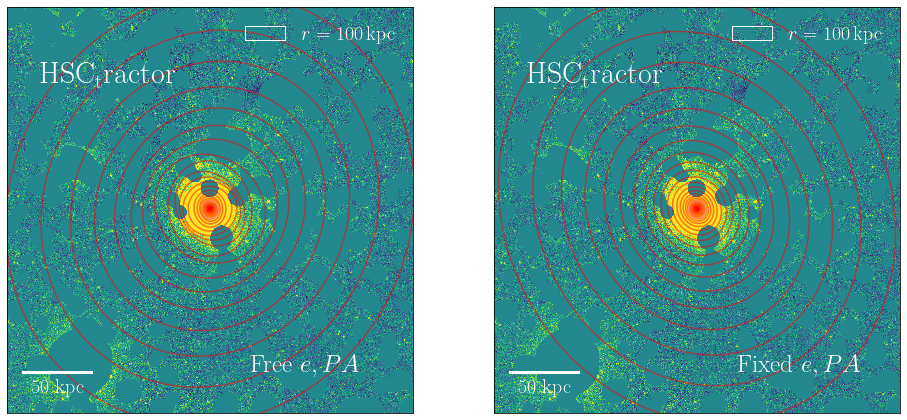

In [91]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0] = display_isophote((~seg_mask)*img_corr, ell_2, pixel_scale, text=prefix, ax=ax[0])
ax[0].text(cen*1.2, cen*0.2, r'$\mathrm{Free}\ e, PA$', color='w', fontsize=25)
r = 100/(2.5*phys_size)
e = Ellipse(xy=(cen, cen), height=2*r, width=2*r)
e.set_facecolor('none')
e.set_edgecolor('w')
e.set_label('$r=100\mathrm{\,kpc}$')
ax[0].add_patch(e)
leg = ax[0].legend(fontsize=20, frameon=False)
leg.get_frame().set_facecolor('none')
for text in leg.get_texts():
    text.set_color('w')

ax[1] = display_isophote((~seg_mask)*img_corr, ell_3, pixel_scale, text=prefix, ax=ax[1])
ax[1].text(cen*1.2, cen*0.2, r'$\mathrm{Fixed}\ e, PA$', color='w', fontsize=25)
r = 100/(2.5*phys_size)
e = Ellipse(xy=(cen, cen), height=2*r, width=2*r)
e.set_facecolor('none')
e.set_edgecolor('w')
e.set_label('$r=100\mathrm{\,kpc}$')
ax[1].add_patch(e)
leg = ax[1].legend(fontsize=20, frameon=False)
leg.get_frame().set_facecolor('none')
for text in leg.get_texts():
    text.set_color('w')

In [39]:
def SBP_shape(ell_free, ell_fix, redshift, ang_scale, zeropoint, ax=None, x_min=1.0, 
                            x_max=4.0, physical_unit=False, 
                            angular_unit=True, show_dots=False, vertical_line=True, 
                            vertical_pos=100, linecolor='firebrick', label=None):
    """Display the 1-D profiles."""
    
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        fig.subplots_adjust(left=0.0, right=1.0, 
                            bottom=0.0, top=1.0,
                            wspace=0.00, hspace=0.00)

        ax1 = fig.add_axes([0.08, 0.07, 0.85, 0.48])
        ax2 = fig.add_axes([0.08, 0.55, 0.85, 0.20])
        ax3 = fig.add_axes([0.08, 0.75, 0.85, 0.20])
        ax1.tick_params(direction='in')
        ax2.tick_params(direction='in')
        ax3.tick_params(direction='in')
    else:
        ax1 = ax[0]
        ax2 = ax[1]
        ax3 = ax[2]
        ax1.tick_params(direction='in')
        ax2.tick_params(direction='in')
        ax3.tick_params(direction='in')
    
    # Calculate cosmological distance
    from astropy import cosmology
    cosmos = cosmology.FlatLambdaCDM(H0=70, Om0=0.27)
    ang_dis = cosmos.angular_diameter_distance(redshift)
    phys_size = ang_dis.value/206265*1000 # kpc/arcsec
    
    # Calculate mean ellipticity and pa, which are used for fixed fitting
    interval = np.intersect1d(np.where(ell_free['sma'].data*pixel_scale*phys_size > 20),
               np.where(ell_free['sma'].data*pixel_scale*phys_size < 50))
    mean_e = ell_free['ell'][interval].mean()
    stdev_e = ell_free['ell'][interval].std()
    mean_pa = ell_free['pa_norm'][interval].mean()
    stdev_pa = ell_free['pa_norm'][interval].std()

    # 1-D profile
    if physical_unit is True:
        x = ell_fix['sma']*ang_scale*phys_size
        y = -2.5*np.log10(ell_fix['intens'].data/(ang_scale*phys_size)**2)+zeropoint
        y_upper = -2.5*np.log10((ell_fix['intens']+ell_fix['int_err'])/(ang_scale*phys_size)**2)+zeropoint
        y_lower = -2.5*np.log10((ell_fix['intens']-ell_fix['int_err'])/(ang_scale*phys_size)**2)+zeropoint
        upper_yerr = y_lower-y
        lower_yerr = y-y_upper
        asymmetric_error = [lower_yerr, upper_yerr]
        xlabel = r'$(R/\mathrm{kpc})^{1/4}$'
        ylabel = r'$\mu\,[\mathrm{mag/kpc^2}]$'
        
    if angular_unit is True:
        x = ell_fix['sma']*ang_scale
        y = -2.5*np.log10(ell_fix['intens']/(ang_scale)**2)+zeropoint
        y_upper = -2.5*np.log10((ell_fix['intens']+ell_fix['int_err'])/(ang_scale)**2)+zeropoint
        y_lower = -2.5*np.log10((ell_fix['intens']-ell_fix['int_err'])/(ang_scale)**2)+zeropoint
        upper_yerr = y_lower-y
        lower_yerr = y-y_upper
        asymmetric_error = [lower_yerr, upper_yerr]
        xlabel = r'$(R/\mathrm{arcsec})^{1/4}$'
        ylabel = r'$\mu\,[\mathrm{mag/arcsec^2}]$'
        
    if angular_unit is True and physical_unit is True:
        raise SyntaxError('angular_unit & physical_unit should be different')
    if angular_unit is False and physical_unit is False:
        raise SyntaxError('angular_unit & physical_unit should be different')
    
    # ax1.grid(linestyle='--', alpha=0.4, linewidth=2)
    
    if show_dots is True:
        ax1.errorbar((x ** 0.25), 
                 y,
                 yerr=asymmetric_error,
                 color='k', alpha=0.2, fmt='o', 
                 capsize=4, capthick=1, elinewidth=1)
    ax1.plot(x**0.25, y, color=linecolor, linewidth=4, label=r'$\mathrm{'+label+'}$')
    ax1.fill_between(x**0.25, y_upper, y_lower, color=linecolor, alpha=0.3)
    ax1.axvline(x=vertical_pos**0.25, ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], 
                    color='gray', linestyle='--', linewidth=3)
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(25)
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(25)
    ax1.set_xlim(x_min, x_max)
    ax1.set_xlabel(xlabel, fontsize=30)
    ax1.set_ylabel(ylabel, fontsize=30)
    ax1.invert_yaxis()
    if label is not None:
        ax1.legend(fontsize=20, frameon=False)
    
    # Ellipticity profile
    # ax2.grid(linestyle='--', alpha=0.4, linewidth=2)
    if physical_unit is True:
        x = ell_free['sma']*ang_scale*phys_size
    if angular_unit is True:
        x = ell_free['sma']*ang_scale
    if show_dots is True:
        ax2.errorbar((x ** 0.25), 
                     ell_free['ell'],
                     yerr=ell_free['ell_err'],
                     color='k', alpha=0.4, fmt='o', capsize=4, capthick=2, elinewidth=2)
    ax2.fill_between(x**0.25, ell_free['ell']+ell_free['ell_err'], ell_free['ell']-ell_free['ell_err'], 
                     color=linecolor, alpha=0.3)
    ax2.plot(x**0.25, ell_free['ell'], color=linecolor, linewidth=4)
    ax2.xaxis.set_major_formatter(NullFormatter())
    for tick in ax2.yaxis.get_major_ticks():
        tick.label.set_fontsize(25)
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(0,0.7)
    ax2.set_ylabel(r'$e$', fontsize=35)
    ytick_pos = [0, 0.2, 0.4, 0.6]
    ax2.set_yticks(ytick_pos)
    ax2.set_yticklabels([r'$'+str(round(i,2))+'$' for i in ytick_pos])
    # ax2.axhline(y = ell_free['ell'][~np.isnan(ell_free['ell'].data)].mean(),
    #           color=linecolor, alpha=1, linestyle = '-.', linewidth = 2)
    ax2.axhline(y = mean_e,
               color=linecolor, alpha=1, linestyle = '-.', linewidth = 2)

    # Position Angle profile
    #ax3.grid(linestyle='--', alpha=0.4, linewidth=2)
    from kungpao import utils
    pa_err = np.array([utils.normalize_angle(pa, lower=-90, 
                                             upper=90, b=True) for pa in ell_free['pa_err']])
    if show_dots is True:
        ax3.errorbar((x ** 0.25), 
                     ell_free['pa_norm'], yerr=pa_err,
                     color='k', alpha=0.4, fmt='o', capsize=4, capthick=2, elinewidth=2)
    ax3.fill_between(x**0.25, ell_free['pa_norm']+pa_err, ell_free['pa_norm']-pa_err, 
                     color=linecolor, alpha=0.3)
    ax3.plot(x**0.25, ell_free['pa_norm'], color=linecolor, linewidth=4)
    ax3.xaxis.set_major_formatter(NullFormatter())
    
    for tick in ax3.yaxis.get_major_ticks():
        tick.label.set_fontsize(25)
    
    ax3.set_xlim(x_min, x_max)
    ax3.set_ylabel(r'$\mathrm{PA\ [deg]}$', fontsize=25)
    
    #ax3.axhline(y = ell_free['pa_norm'][~np.isnan(ell_free['pa_norm'].data)].mean(),
    #           color=linecolor, alpha=1, linestyle = '-.', linewidth = 2)
    ax3.axhline(y = mean_pa,
               color=linecolor, alpha=1, linestyle = '-.', linewidth = 2)
    
    ax4 = ax3.twiny() 
    ax4.tick_params(direction='in')
    lin_label = [1, 2, 5, 10, 50, 100, 150]
    lin_pos = [i**0.25 for i in lin_label]
    ax4.set_xticks(lin_pos)
    ax4.set_xlim(ax3.get_xlim())
    ax4.set_xlabel(r'$\mathrm{kpc}$', fontsize=30)
    ax4.xaxis.set_label_coords(1, 1.05)
    
    ax4.set_xticklabels([r'$\mathrm{'+str(i)+'}$' for i in lin_label], fontsize=25)
    for tick in ax4.xaxis.get_major_ticks():
        tick.label.set_fontsize(25)
        
        
    if vertical_line is True:
        ax1.axvline(x=vertical_pos**0.25, ymin=0, ymax=1, 
                    color='gray', linestyle='--', linewidth=3)
        ax2.axvline(x=vertical_pos**0.25, ymin=0, ymax=1, 
                    color='gray', linestyle='--', linewidth=3)
        ax3.axvline(x=vertical_pos**0.25, ymin=0, ymax=1, 
                    color='gray', linestyle='--', linewidth=3)
        
    if ax is None:
        return fig
    return ax1, ax2, ax3

#### Display 1-D Surface Brightness Profile

/anaconda3/envs/iraf27/lib/python2.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in log10
/anaconda3/envs/iraf27/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in log10
/anaconda3/envs/iraf27/lib/python2.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in log10


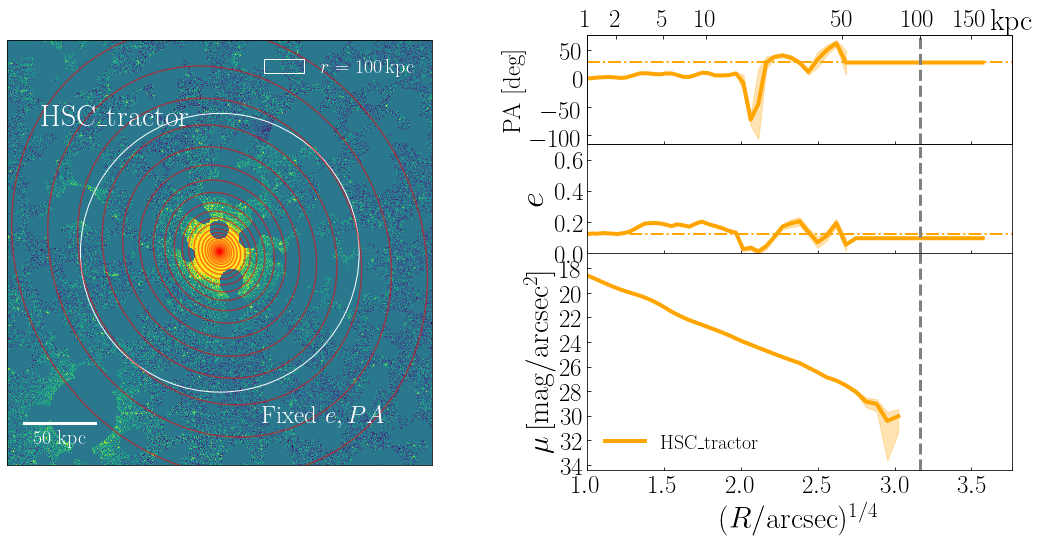

In [93]:
from astropy.table import Table, Column
decals_ellipse_fix = Table.read('./Data/img_HSC_tractor_ellip_3.csv', format='csv')
decals_ellipse_free = Table.read('./Data/img_HSC_tractor_ellip_2.csv', format='csv')
seg_mask = fits.open('msk_HSC_tractor.fits')[0].data.astype(bool)
img_corr = fits.open('img_HSC_tractor.fits')[0].data

fig = plt.figure(figsize=(18,8))
grid = plt.GridSpec(4, 9, wspace=0.5, hspace=0.0)

ax4 = fig.add_subplot(grid[0:4, 0:4])
ax4 = display_isophote((~seg_mask)*img_corr, ell_3, 0.168, text='HSC\_tractor', ax=ax4, contrast=0.19)
ax4.text(cen*1.2, cen*0.2, r'$\mathrm{Fixed}\ e, PA$', color='w', fontsize=25)
r = 100/(0.168*phys_size)
e = Ellipse(xy=(cen, cen), height=2*r, width=2*r)
e.set_facecolor('none')
e.set_edgecolor('w')
e.set_label('$r=100\mathrm{\,kpc}$')
ax4.add_patch(e)
leg = ax4.legend(fontsize=20, frameon=False)
leg.get_frame().set_facecolor('none')
for text in leg.get_texts():
    text.set_color('w')


ax3 = fig.add_subplot(grid[0, 5:9])
ax2 = fig.add_subplot(grid[1, 5:9])
ax1 = fig.add_subplot(grid[2:, 5:9])
ax1.tick_params(direction='in')
ax2.tick_params(direction='in')
ax3.tick_params(direction='in')

ax1, ax2, ax3 = SBP_shape(decals_ellipse_free, decals_ellipse_fix, 
                          redshift, 0.168, 27.0, ax = [ax1, ax2, ax3], 
                            physical_unit=False, angular_unit=True, x_max=(200 ** 0.25), 
                            vertical_line=True, show_dots=False, linecolor='orange',
                            label='HSC\_tractor')
#ax1.invert_yaxis()
plt.savefig('./Figures/HSC_tractor.png', bbox_inches='tight', dpi=250)

In [94]:
# You can plot 1-D SBP using this
def SBP_single_shape(ell_free, ell_fix, redshift, ang_scale, zeropoint, ax=None, x_min=1.0, 
                            x_max=4.0, physical_unit=False, 
                            angular_unit=True, show_dots=False, vertical_line=True, 
                            vertical_pos=100, linecolor='firebrick', 
                            linestyle='-', label=None):
    """Display the 1-D profiles."""
    
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        fig.subplots_adjust(left=0.0, right=1.0, 
                            bottom=0.0, top=1.0,
                            wspace=0.00, hspace=0.00)

        ax1 = fig.add_axes([0.08, 0.07, 0.85, 0.48])
        ax1.tick_params(direction='in')
    else:
        ax1 = ax
        ax1.tick_params(direction='in')
    
    # Calculate cosmological distance
    from astropy import cosmology
    cosmos = cosmology.FlatLambdaCDM(H0=70, Om0=0.27)
    ang_dis = cosmos.angular_diameter_distance(redshift)
    phys_size = ang_dis.value/206265*1000 # kpc/arcsec
    
    # Calculate mean ellipticity and pa, which are used for fixed fitting
    interval = np.intersect1d(np.where(ell_free['sma'].data*pixel_scale*phys_size > 20),
               np.where(ell_free['sma'].data*pixel_scale*phys_size < 50))
    mean_e = ell_free['ell'][interval].mean()
    stdev_e = ell_free['ell'][interval].std()
    mean_pa = ell_free['pa_norm'][interval].mean()
    stdev_pa = ell_free['pa_norm'][interval].std()

    # 1-D profile
    if physical_unit is True:
        x = ell_fix['sma']*ang_scale*phys_size
        y = -2.5*np.log10(ell_fix['intens'].data/(ang_scale)**2)+zeropoint
        y_upper = -2.5*np.log10((ell_fix['intens']+ell_fix['int_err'])/(ang_scale)**2)+zeropoint
        y_lower = -2.5*np.log10((ell_fix['intens']-ell_fix['int_err'])/(ang_scale)**2)+zeropoint
        upper_yerr = y_lower-y
        lower_yerr = y-y_upper
        asymmetric_error = [lower_yerr, upper_yerr]
        xlabel = r'$(R/\mathrm{kpc})^{1/4}$'
        ylabel = r'$\mu\,[\mathrm{mag/arcsec^2}]$'
        
    if angular_unit is True:
        x = ell_fix['sma']*ang_scale
        y = -2.5*np.log10(ell_fix['intens']/(ang_scale)**2)+zeropoint
        y_upper = -2.5*np.log10((ell_fix['intens']+ell_fix['int_err'])/(ang_scale)**2)+zeropoint
        y_lower = -2.5*np.log10((ell_fix['intens']-ell_fix['int_err'])/(ang_scale)**2)+zeropoint
        upper_yerr = y_lower-y
        lower_yerr = y-y_upper
        asymmetric_error = [lower_yerr, upper_yerr]
        xlabel = r'$(R/\mathrm{arcsec})^{1/4}$'
        ylabel = r'$\mu\,[\mathrm{mag/arcsec^2}]$'
        
    if angular_unit is True and physical_unit is True:
        raise SyntaxError('angular_unit & physical_unit should be different')
    if angular_unit is False and physical_unit is False:
        raise SyntaxError('angular_unit & physical_unit should be different')
    
    # ax1.grid(linestyle='--', alpha=0.4, linewidth=2)
    
    if show_dots is True:
        ax1.errorbar((x ** 0.25), 
                 y,
                 yerr=asymmetric_error,
                 color='k', alpha=0.2, fmt='o', 
                 capsize=4, capthick=1, elinewidth=1)
    ax1.plot(x**0.25, y, color=linecolor, linewidth=4, linestyle=linestyle,
             label=r'$\mathrm{'+label+'}$')
    ax1.fill_between(x**0.25, y_upper, y_lower, color=linecolor, alpha=0.3)
    ax1.axvline(x=vertical_pos**0.25, ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], 
                    color='gray', linestyle='--', linewidth=3)
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(25)
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(25)
    ax1.set_xlim(x_min, x_max)
    ax1.set_xlabel(xlabel, fontsize=30)
    ax1.set_ylabel(ylabel, fontsize=30)
    ax1.invert_yaxis()
    if label is not None:
        ax1.legend(fontsize=20, frameon=False)
    
    
    ax4 = ax1.twiny() 
    ax4.tick_params(direction='in')
    lin_label = [1, 2, 5, 10, 50, 100, 150]
    lin_pos = [i**0.25 for i in lin_label]
    ax4.set_xticks(lin_pos)
    ax4.set_xlim(ax1.get_xlim())
    ax4.set_xlabel(r'$\mathrm{kpc}$', fontsize=30)
    ax4.xaxis.set_label_coords(1, 1.05)
    
    ax4.set_xticklabels([r'$\mathrm{'+str(i)+'}$' for i in lin_label], fontsize=25)
    for tick in ax4.xaxis.get_major_ticks():
        tick.label.set_fontsize(25)
        
        
    if vertical_line is True:
        ax1.axvline(x=vertical_pos**0.25, ymin=0, ymax=1, 
                    color='gray', linestyle='--', linewidth=3)
        
    if ax is None:
        return fig
    return ax1

In [95]:
ra_cen = 129.603676                  # ra of object
dec_cen = -1.606419                  # dec of object
redshift = 0.052043

from astropy import cosmology
cosmos = cosmology.FlatLambdaCDM(H0=70, Om0=0.27)
ang_dis = cosmos.angular_diameter_distance(redshift)
phys_size = ang_dis.value/206265*1000 # kpc/arcsec
print 'At this redshift, 1 arcsec =', phys_size, 'kpc'

HSC_pixel_scale = 0.168
DECaLS_pixel_scale = 0.262
Dragonfly_pixel_scale = 2.5
SDSS_pixel_scale = 0.395

At this redshift, 1 arcsec = 1.01616618242 kpc


In [96]:
from astropy.table import Table, Column
DECaLS_ellipse_fix = Table.read('./Data/img_DECaLS_ellip_nocomp_3.csv', format='csv')
DECaLS_ellipse_free = Table.read('./Data/img_decals_ellip_nocomp_2.csv', format='csv')
DECaLS_mask = fits.open('msk_DECaLS.fits')[0].data.astype(bool)
DECaLS_img = fits.open('img_DECaLS.fits')[0].data

HSC_ellipse_fix = Table.read('./Data/img_HSC_ellip_3.csv', format='csv')
HSC_ellipse_free = Table.read('./Data/img_HSC_ellip_2.csv', format='csv')
HSC_mask = fits.open('msk_HSC.fits')[0].data.astype(bool)
HSC_img = fits.open('img_HSC.fits')[0].data

SDSS_ellipse_fix = Table.read('./Data/img_SDSS_ellip_3.csv')
SDSS_ellipse_free = Table.read('./Data/img_SDSS_ellip_2.csv')
SDSS_ellipse_free['pa_norm'] -= 90
SDSS_mask = fits.open('msk_SDSS.fits')[0].data.astype(bool)
SDSS_img = fits.open('img_SDSS.fits')[0].data

HSC_tractor_ellipse_fix = Table.read('./Data/img_HSC_tractor_ellip_3.csv', format='csv')
HSC_tractor_ellipse_free = Table.read('./Data/img_HSC_tractor_ellip_2.csv', format='csv')
HSC_tractor_mask = fits.open('msk_HSC_tractor.fits')[0].data.astype(bool)
HSC_tractor_img = fits.open('img_HSC_tractor.fits')[0].data

/anaconda3/envs/iraf27/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log10
/anaconda3/envs/iraf27/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in log10
/anaconda3/envs/iraf27/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log10


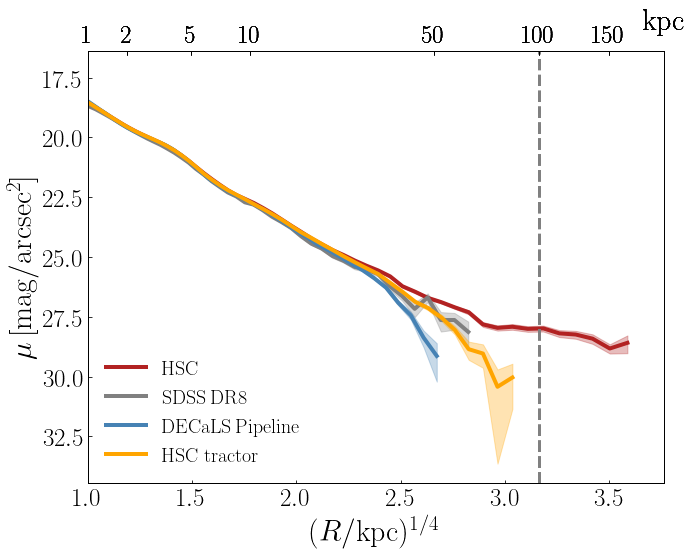

In [98]:
fig, ax1 = plt.subplots(figsize=(8, 6))
fig.subplots_adjust(left=0.0, right=1.0, 
                    bottom=0.0, top=1.0,
                    wspace=0.00, hspace=0.00)


ax1.tick_params(direction='in')

SBP_axes = ax1

SBP_axes = SBP_single_shape(HSC_ellipse_free, HSC_ellipse_fix, 0.052043, 
                          HSC_pixel_scale, 27, ax = SBP_axes, 
                            physical_unit=True, angular_unit=False, x_max=(200 ** 0.25), 
                            vertical_line=True, show_dots=False, linecolor='firebrick',
                            label="HSC")
SBP_axes = SBP_single_shape(SDSS_ellipse_free, SDSS_ellipse_fix, 0.052043, 
                          SDSS_pixel_scale, 22.5, ax = SBP_axes, 
                            physical_unit=True, angular_unit=False, x_max=(200 ** 0.25), 
                            vertical_line=True, show_dots=False, linecolor='gray',
                            label="SDSS\,DR8")
SBP_axes = SBP_single_shape(DECaLS_ellipse_free, DECaLS_ellipse_fix, 0.052043,
                          DECaLS_pixel_scale, 22.5, ax = SBP_axes, 
                            physical_unit=True, angular_unit=False, x_max=(200 ** 0.25), 
                            vertical_line=True, show_dots=False, linecolor='steelblue',
                            label='DECaLS\,Pipeline')
SBP_axes = SBP_single_shape(HSC_tractor_ellipse_free, HSC_tractor_ellipse_fix, 0.052043,
                          HSC_pixel_scale, 27, ax = SBP_axes, 
                            physical_unit=True, angular_unit=False, x_max=(200 ** 0.25), 
                            vertical_line=True, show_dots=False, linecolor='orange',
                            label='HSC\ tractor')
ax1.invert_yaxis()
plt.savefig('./Figures/low_z_1d_comparison.png', dpi=200, bbox_inches='tight')